(4). [15] Create new features: Transform, extend or combine the existing features, or add new features from external sources, to create a few new features (at least 3) with the aim to better capture the problem domain and the target outcome. Justify the steps and choices you are making. In the grading, consideration will be given to the creativity and domain knowledge shown in preparing the new features. Use code to show that your new features are indeed useful for the target prediction problem. Add these features to your clean dataset and save it as a CSV file with a self explanatory name. 

In [182]:
#Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#For showing plots directly in the notebook run the command below
%matplotlib inline

# For saving multiple plots into a single pdf file
from matplotlib.backends.backend_pdf import PdfPages

# Hide ipykernel warnings
import warnings
warnings.filterwarnings('ignore')

# Set pandas to display all columns
pd.set_option('display.max_columns', None)


# Import seaborn library
import seaborn as sns




In [183]:
# Read from csv file into a data frame
df = pd.read_csv('PostDQP.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

In [184]:
# Convert all object columns to category
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')

# Strip the '.' and everything to the right for 'ZipCode'
df['ZipCode'] = df['ZipCode'].astype(str).str.split('.').str[0]

# Convert 'ZipCode' back to categorical
df['ZipCode'] = df['ZipCode'].astype("category")

df['IncidentStartDate'] = pd.to_datetime(df['IncidentStartDate'])

In [185]:
df.dtypes

ObjectID                    int64
Damage                   category
StreetType               category
ZipCode                  category
CALFIREUnit              category
County                   category
IncidentStartDate        category
StructureType            category
RoofConstruction         category
VentScreen               category
ExteriorSiding           category
WindowPane               category
Deck/PorchOnGrade        category
Deck/PorchElevated       category
AssessedImprovedValue     float64
YearBuilt                   int64
Latitude                  float64
Longitude                 float64
dtype: object

In [186]:
df['StructureType'].unique()

['SINGLE FAMILY RESIDENCE SINGLE STORY', 'UTILITY MISC STRUCTURE', 'SINGLE FAMILY RESIDENCE MULTI STORY', 'MOBILE HOME DOUBLE WIDE', 'MOBILE HOME SINGLE WIDE', 'OTHER', 'COMMERCIAL BUILDING SINGLE STORY']
Categories (7, object): ['COMMERCIAL BUILDING SINGLE STORY', 'MOBILE HOME DOUBLE WIDE', 'MOBILE HOME SINGLE WIDE', 'OTHER', 'SINGLE FAMILY RESIDENCE MULTI STORY', 'SINGLE FAMILY RESIDENCE SINGLE STORY', 'UTILITY MISC STRUCTURE']

### Feature 1: Season
- Season may be a powerful predictor for wildfire damage because it captures interactions between climate factors, vegetation conditions, wind patterns, and human activities that directly impact the likelihood of fire ignition, spread, and intensity
- These factors change in a cyclical pattern throughout the year

In [187]:
# Get month from IncidentStartDate
df['Month'] = df['IncidentStartDate'].dt.month

In [188]:
df['Month']

0       10
1        9
2        8
3        8
4        1
        ..
9995     9
9996    11
9997    11
9998    11
9999     9
Name: Month, Length: 10000, dtype: int32

In [189]:
# Declare seasons
Winter = [12, 1, 2]
Spring = [3, 4, 5]
Summer = [6, 7, 8]
Fall = [9, 10, 11]

df['Season'] = ''

In [190]:
for i in range(len(df)):
    month = df.loc[i, 'Month']
    
    if month in Winter:
        df.loc[i, 'Season'] = 'Winter'
    elif month in Spring:
        df.loc[i, 'Season'] = 'Spring'
    elif month in Summer:
        df.loc[i, 'Season'] = 'Summer'
    elif month in Fall:
        df.loc[i, 'Season'] = 'Fall'
    else:
        df.loc[i, 'Season'] = 'Unknown'  # Fallback for unexpected values

In [191]:
print(len(df[df['Season']=='Spring']))
print(len(df[df['Season']=='Fall']))
print(len(df[df['Season']=='Summer']))
print(len(df[df['Season']=='Winter']))

16
4887
2505
2592


In the dataset, Spring is underrepresented. This could have been caused by an array of factors, such as data collection bias or actual weather and fire conditions in certain regions. <br> <br>
Because the distribution of incidents across seasons is highly imbalanced, the raw counts of seasons such as Fall, Summer, and Winter will dominate analysis. Normalization will ensure that each season is represented proportionally, regardless of the number of incidents. This will allow us to analyze the relative likelihood of damage for each season.

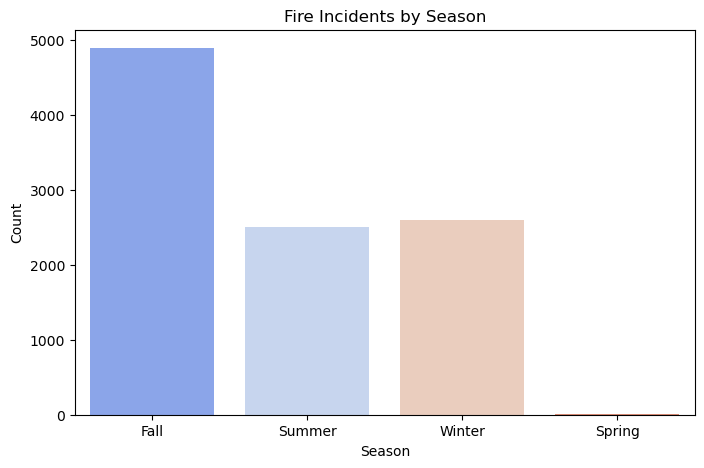

In [192]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Season'], palette="coolwarm")
plt.title("Fire Incidents by Season")
plt.xlabel("Season")
plt.ylabel("Count")
plt.show()

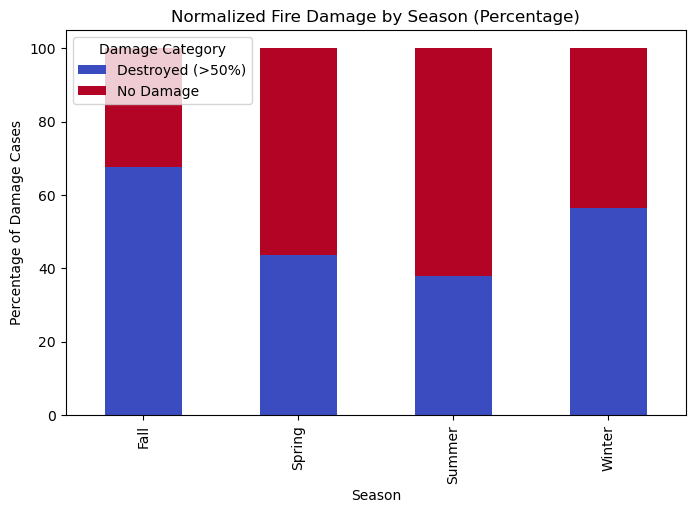

In [193]:
# Group by season and damage category, then count the incidents
season_counts = df.groupby(['Season', 'Damage']).size().unstack()

# Normalize by dividing each damage count by the total count in the season (turning it into percentages)
season_counts_normalized = season_counts.div(season_counts.sum(axis=1), axis=0) * 100

# Plot the normalized stacked bar chart
season_counts_normalized.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(8, 5))

# Add labels and title
plt.title("Normalized Fire Damage by Season (Percentage)")
plt.xlabel("Season")
plt.ylabel("Percentage of Damage Cases")
plt.legend(title="Damage Category", loc="upper left")
plt.show()

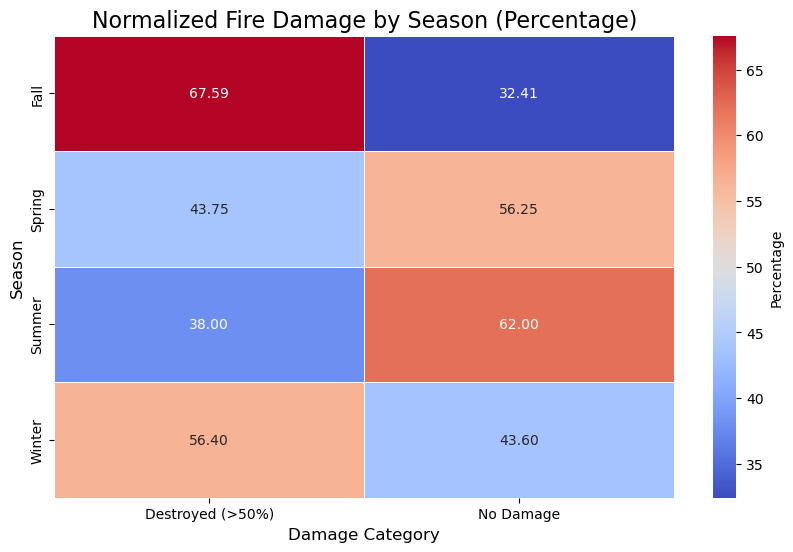

In [194]:
# Normalize by dividing each damage count by the total count in the season (turning it into percentages)
season_counts_normalized = season_counts.div(season_counts.sum(axis=1), axis=0) * 100

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(season_counts_normalized, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Percentage'}, linewidths=0.5)

# Add title and labels
plt.title("Normalized Fire Damage by Season (Percentage)", fontsize=16)
plt.xlabel("Damage Category", fontsize=12)
plt.ylabel("Season", fontsize=12)
plt.show()

In [195]:
#Group by season and damage category, then count the incidents
season_counts = df.groupby(['Season', 'Damage']).size().unstack()

# Normalize by dividing each damage count by the total count in the season (turning it into percentages)
season_counts_normalized = season_counts.div(season_counts.sum(axis=1), axis=0) * 100

# Display the table of likelihoods (percentages)
season_counts_normalized

Damage,Destroyed (>50%),No Damage
Season,,
Fall,67.587477,32.412523
Spring,43.750000,56.250000
Summer,38.003992,61.996008
Winter,56.404321,43.595679


In [196]:
# Count the total number of incidents in each season
season_frequency = df['Season'].value_counts()

# Display the frequency of incidents per season
print(season_frequency)

# If you want to determine the frequency of incidents by damage type and season:
damage_by_season = df.groupby(['Season', 'Damage']).size().unstack(fill_value=0)

# Display the table of incident frequencies by damage type and season
print(damage_by_season)

Season
Fall      4887
Winter    2592
Summer    2505
Spring      16
Name: count, dtype: int64
Damage  Destroyed (>50%)  No Damage
Season                             
Fall                3303       1584
Spring                 7          9
Summer               952       1553
Winter              1462       1130


In [197]:
df['Season'] = df['Season'].astype('category')

### Interpretation of Results
1. Incident Frequency by Season:
The distribution of incident frequency across seasons is uneven:
- Fall has the highest number of incidents
- Winter and Summer have significantly fewer incidents than Fall but still have a notable number of incidents
- Spring is severely underrepresented in the dataset, which suggests a data collection issue or true seasonal anomaly (e.g., fewer incidents occuring in the Spring)
2. Damage Distribution
- Fall has a large proportion of Destroyed incidents compared to No Damage, indicating that the majority of incidents during Fall caused significant damage to properties
- Although Winter has fewer incidents than Fall, the damage distribution is relatively balanced, with a substantial portion of incidents resulting in significant damage
- Summer incidents are more heavily weighted towards No Damage when compared to Fall and Winter
- The normalized proportions of incident damage severity for Spring are relatively balanced. However, due to the small number of records for Spring, it necessary to validate the data quality for Spring prior to drawing final conclusions

### Conclusion
1. Underrepresentation of Spring
- A low number of records in the Spring could be attributed to higher humidity and rainfall, leading to less dry fuel and reduced fire risk
2. Fall is the most incident-prone season
- Fall is known to be the peak of wildfire season in many areas, due to a combination of factors like high winds, dry vegetation, and low humidity
3. Severe damage in Winter
- In some regions, dry winters combined with high winds can still cause wildfires to ignite and spread
4. Moderate incident frequency and damage in Summer

### Feature 2: RoofSidingInteraction (Categorical)
- This new feature represents the specific combination of exterior siding and roof construction for each property
- In Part 3, we noted common combinations of roof and siding materials. We will use this new feature to determine whether these combinations might amplify vulnerability to property damage due to wildfires
- We will also explore whether certain combinations might provide enhanced resilience


In [198]:
df['RoofSidingInteraction'] = df['RoofConstruction'].astype(str) + '_' + df['ExteriorSiding'].astype(str)

In [199]:
df['RoofSidingInteraction'] = df['RoofSidingInteraction'].astype('category')

In [200]:
df['RoofSidingInteraction'].unique()

['FIRE RESISTANT_FIRE/IGNITION RESISTANT', 'FIRE RESISTANT_COMBUSTIBLE', 'ASPHALT_WOOD', 'ASPHALT_STUCCO BRICK CEMENT', 'OTHER_OTHER', ..., 'TILE_COMBUSTIBLE', 'COMBUSTIBLE_FIRE/IGNITION RESISTANT', 'TILE_OTHER', 'UNKNOWN_OTHER', 'TILE_UNKNOWN']
Length: 36
Categories (36, object): ['ASPHALT_COMBUSTIBLE', 'ASPHALT_FIRE/IGNITION RESISTANT', 'ASPHALT_OTHER', 'ASPHALT_STUCCO BRICK CEMENT', ..., 'UNKNOWN_OTHER', 'UNKNOWN_STUCCO BRICK CEMENT', 'UNKNOWN_UNKNOWN', 'UNKNOWN_WOOD']

In [201]:
rf_counts = df.groupby('RoofSidingInteraction').size()
rf_counts

RoofSidingInteraction
ASPHALT_COMBUSTIBLE                        906
ASPHALT_FIRE/IGNITION RESISTANT            472
ASPHALT_OTHER                              113
ASPHALT_STUCCO BRICK CEMENT               1640
ASPHALT_UNKNOWN                             71
ASPHALT_WOOD                              1374
COMBUSTIBLE_COMBUSTIBLE                     88
COMBUSTIBLE_FIRE/IGNITION RESISTANT         13
COMBUSTIBLE_UNKNOWN                         11
FIRE RESISTANT_COMBUSTIBLE                 428
FIRE RESISTANT_FIRE/IGNITION RESISTANT     455
FIRE RESISTANT_UNKNOWN                      77
METAL_COMBUSTIBLE                          154
METAL_FIRE/IGNITION RESISTANT              148
METAL_OTHER                                358
METAL_STUCCO BRICK CEMENT                  177
METAL_UNKNOWN                               39
METAL_WOOD                                 641
OTHER_COMBUSTIBLE                           26
OTHER_FIRE/IGNITION RESISTANT               11
OTHER_OTHER                           

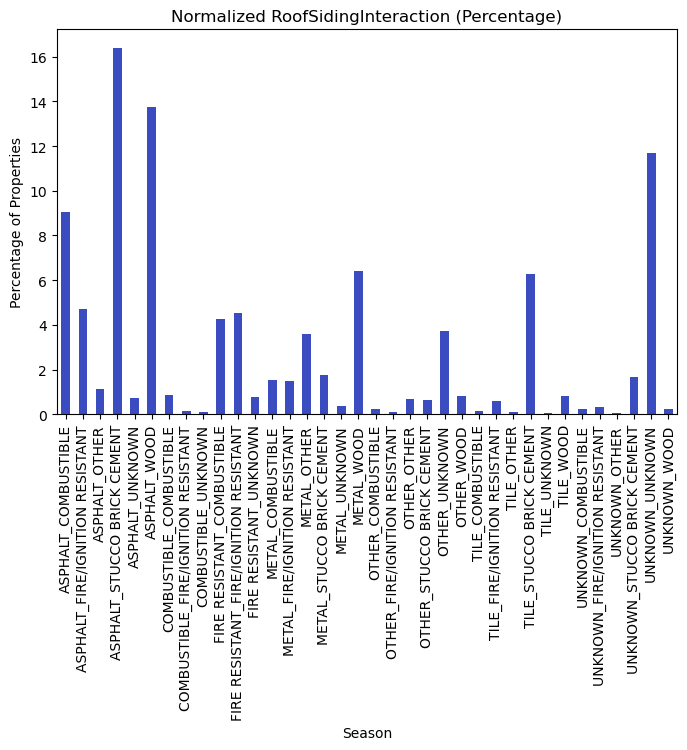

In [202]:
# Normalize by dividing each damage count by the total count in the season (turning it into percentages)
rf_counts_normalized = rf_counts.div(rf_counts.sum(axis=0)) * 100

# Plot the normalized stacked bar chart
rf_counts_normalized.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(8, 5))

# Add labels and title
plt.title("Normalized RoofSidingInteraction (Percentage)")
plt.xlabel("Season")
plt.ylabel("Percentage of Properties")
plt.show()

**Observations:**
- The data is highly skewed, as a few combinations of roof and siding types dominate the feature (ASPHALT_STUCCO BRICK CEMENT, ASPHALT_WOOD)
- Many combinations have very low percentages, indicating they are uncommon in the dataset
- The presence of potentially high-risk combinations such as ASPHALT_COMBUSTIBLE and COMBUSTIBLE_COMBUSTIBLE requires further investigation

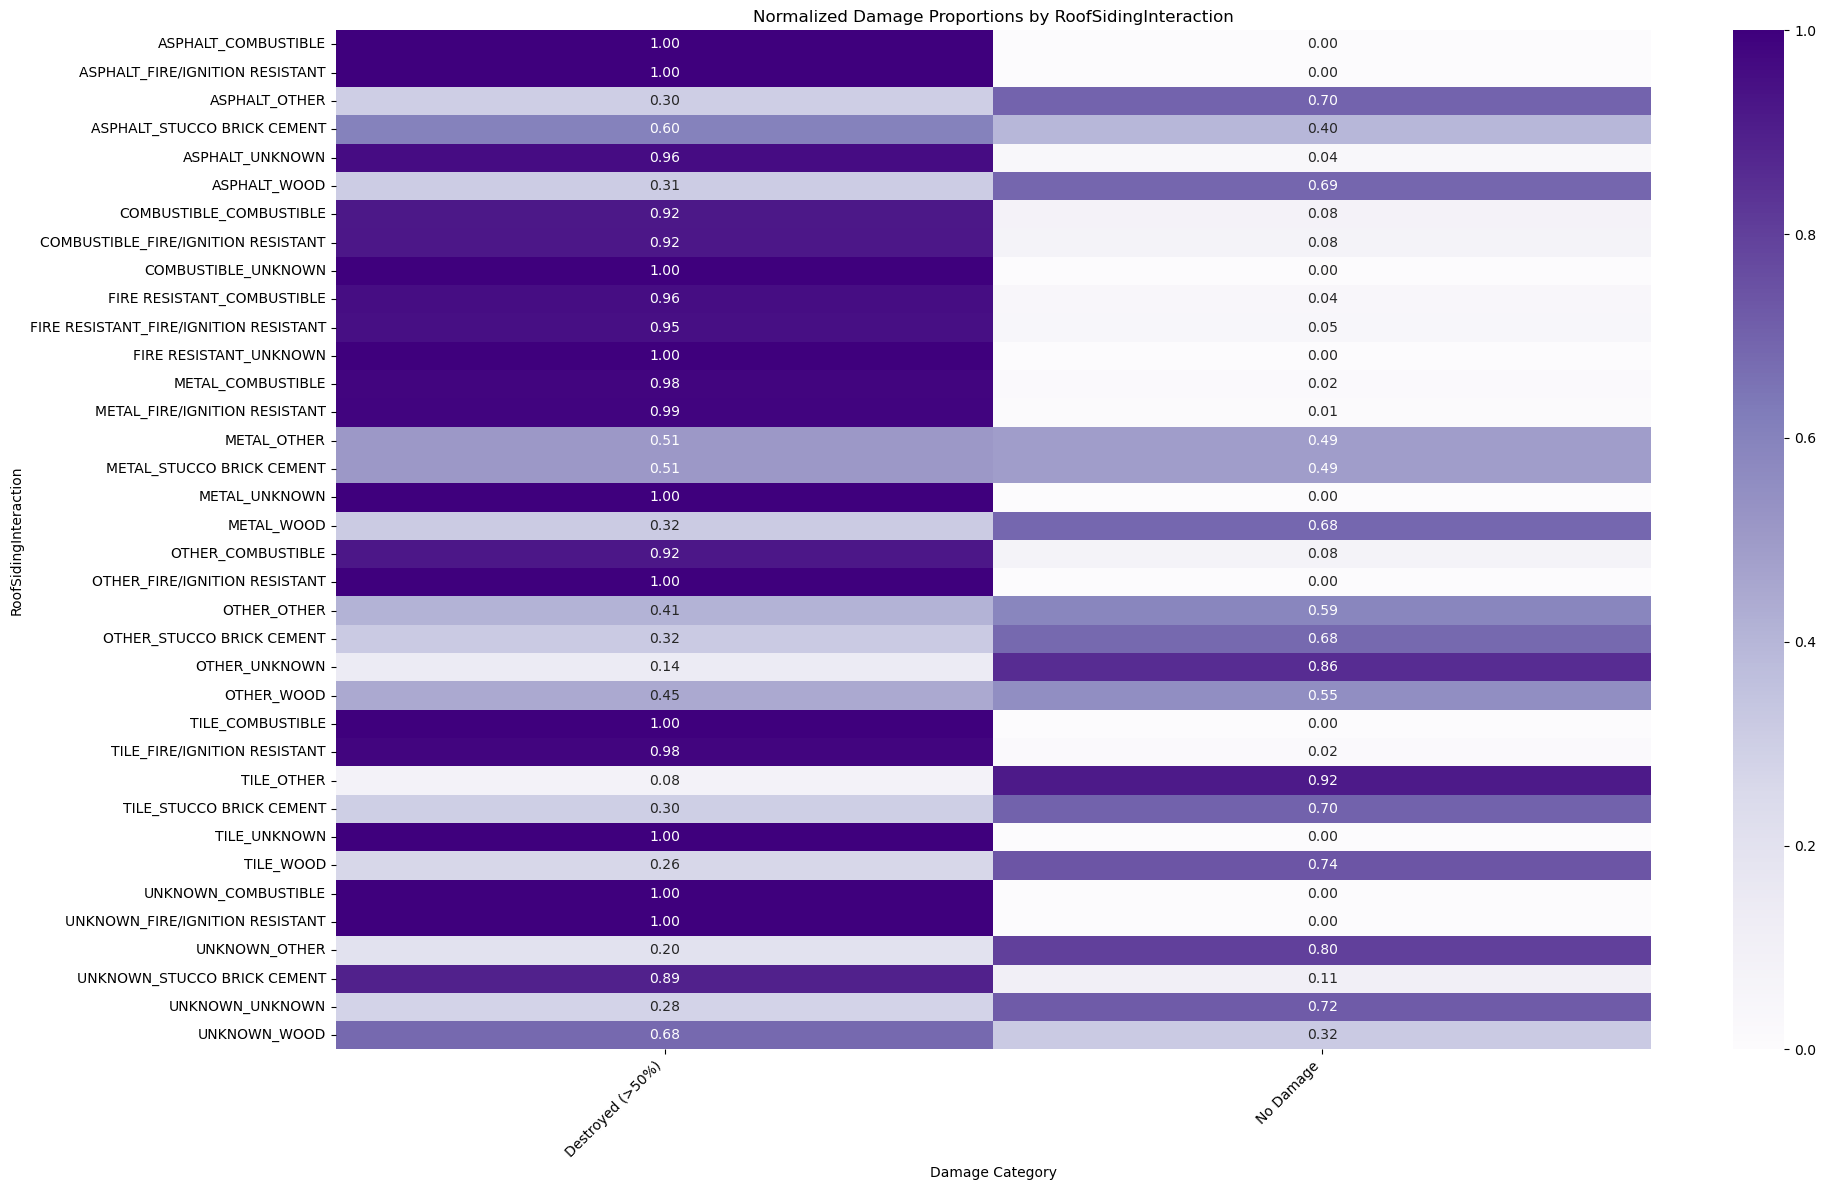

In [203]:
#Group by RoofSidingInteraction and Damage
interaction_damage_counts = df.groupby(['RoofSidingInteraction', 'Damage']).size().unstack(fill_value=0)

#Normalize by RoofSidingInteraction
interaction_damage_normalized = interaction_damage_counts.div(interaction_damage_counts.sum(axis=1), axis=0)

plt.figure(figsize=(20, 12))
sns.heatmap(interaction_damage_normalized, annot=True, cmap='Purples', fmt=".2f")  # fmt=".2f" formats the annotations to two decimal places
plt.title("Normalized Damage Proportions by RoofSidingInteraction")
plt.xlabel("Damage Category")
plt.ylabel("RoofSidingInteraction")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Observations:**
- Several combinations of roof and siding materials show very high proportions of destroyed damage
    - ASPHALT_COMBUSTIBLE
    - ASPHALT_FIRE/IGNITION RESISTANT
    - COMBUSTIBLE_UNKNOWN
    - COMBUSTIBLE_COMBUSTIBLE
    - METAL_UNKNOWN
    - FIRE RESISTANT_UNKNOWN
    - METAL_FIRE/IGNITION RESISTANT
    - TILE_COMBUSTIBLE
    - TILE_FIRE/IGNITION RESISTANT
    - TILE_UNKNOWN
    - UNKNOWN_COMBUSTIBLE
- Combinations involving UNKNOWN generally show a very high proportion of destroyed damage. There needs to be improved data quality in order to derive insights from these records
- Combinations involving COMBUSTIBLE materials are consistently associated with high damage proportions
- Surprisingly, there are combinations involving fire resistant materials with high damage proportions (e.g., OTHER_FIRE/IGNITION RESISTANT). It's possible that properties with fire resistant materials may be more vulnerable to damage if paired with certain materials

### Conclusion
- This new feature highlights the importance of material selection in mitigating wildfire damage. While combustible materials consistently increase risk, specific combinations, even those involving fire-resistant components, can also lead to high damage proportions
- Improving data quality is crucial for a more accurate assessment of material-related risks and for the development of effective strategies to enhance community resilience to wildfires

### Feature 3: ZipCodeDensity
- Approximate the density of structures within a given area
- Higher density might correlate with faster potential response times due to more resources nearby or higher risk due to more structures in a small area

In [204]:
df['ZipCodeDensity'] = df.groupby('ZipCode')['ObjectID'].transform('count')
df['ZipCodeDensity'].describe()


count    10000.000000
mean      1660.787800
std       1480.805827
min          1.000000
25%        237.000000
50%       1178.000000
75%       3564.000000
max       3564.000000
Name: ZipCodeDensity, dtype: float64

**Observations**
- Within each zip code, there are an average of 1,660 properties within each zip code represented in this data set
- The standard deviation is relatively high, indicating significant variability in the number of structures per zip code
- There is at least one zip code in the dataset that only has one property. This could represent rural areas or be an issue with data collection

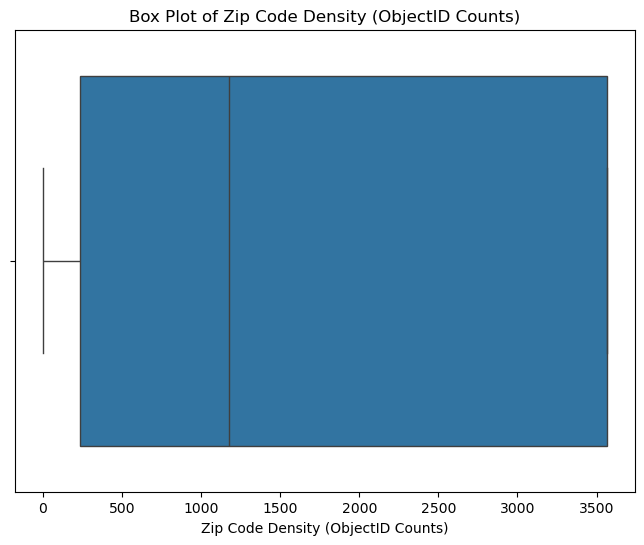

In [205]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['ZipCodeDensity'])
plt.title("Box Plot of Zip Code Density (ObjectID Counts)")
plt.xlabel("Zip Code Density (ObjectID Counts)")
plt.show()

**Observations**
- The data is right-skewed
- There are no outliers
- There is a high degree of variability

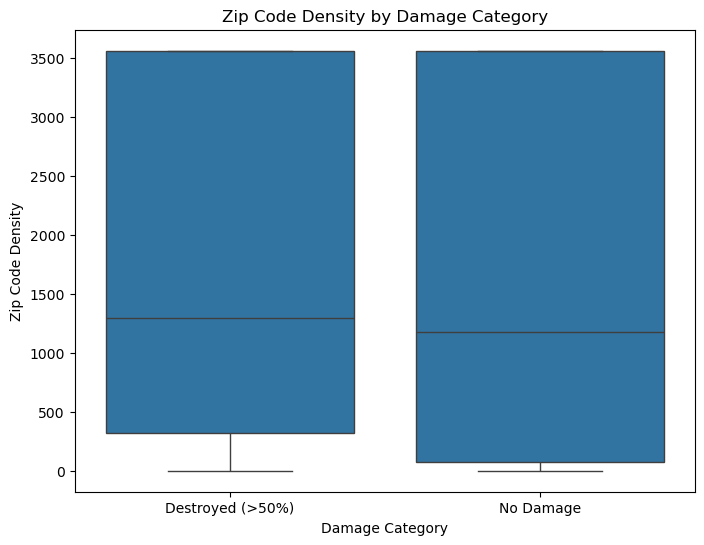

In [206]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Damage', y='ZipCodeDensity', data=df)
plt.xlabel('Damage Category')
plt.ylabel('Zip Code Density')
plt.title('Zip Code Density by Damage Category')
plt.show()

**Observations:**
- There is a very small difference in medians between destroyed vs. no damage. This indicates a weak association between zip code density and damage
- It appears that ZipCodeDensity alone might not be a strong predictor of the damage category. Other factors are likely to be more influential
- Note that ZipCodeDensity is based on ObjectID counts, which represent properties involved in reported wildfire incidents. This likely does not reflect actual density in each zip code

### Conclusion
- Weak Association of Zip Code Density: The observed minimal difference in median ZipCodeDensity between destroyed and undamaged properties suggests a weak association between this feature and damage severity. This indicates that in its current form, ZipCodeDensity is not a strong predictor of damage
- Influence of Other Factors: The analysis points to the likely importance of factors beyond Zip Code Density in determining damage outcomes
- Limitations of Zip Code Density Metric: The current ZipCodeDensity metric, based on ObjectID counts, has limitations. As it reflects the frequency of incidents within a Zip Code rather than the actual density of structures, it may not accurately capture the exposure risk
- Future analysis may refine the measure of density of incidents by using housing unit density or parcel density. This will provide a more robust picture of density in communities

### Feature 4: CALFIREUnitResponseLoad
- Calculate the 'response load' for each CALFireUnit in a geographic location for a specific incident date
- This new feature will indicate how many structures were potentially under the protection of each unit at a given time and place

In [207]:
# Represents the total number of incidents handled by each CAL FIRE unit across all available records
response_load_simple = df.groupby(['CALFIREUnit'])['ObjectID'].count().reset_index(name='CALFIREUnitResponseLoad')
df = df.merge(response_load_simple, on='CALFIREUnit', how='left')

CALFIREUnitResponseLoad represents the total number of incidents a CALFIREUnit has responded to over the entire period of the dataset
- It provides an overall picture of the unit's total workload

In [208]:
response_load_simple.describe()

,CALFIREUnitResponseLoad
count,26.000000
mean,384.615385
std,700.090741
min,7.000000
25%,73.750000
50%,111.500000
75%,279.250000
max,2626.000000


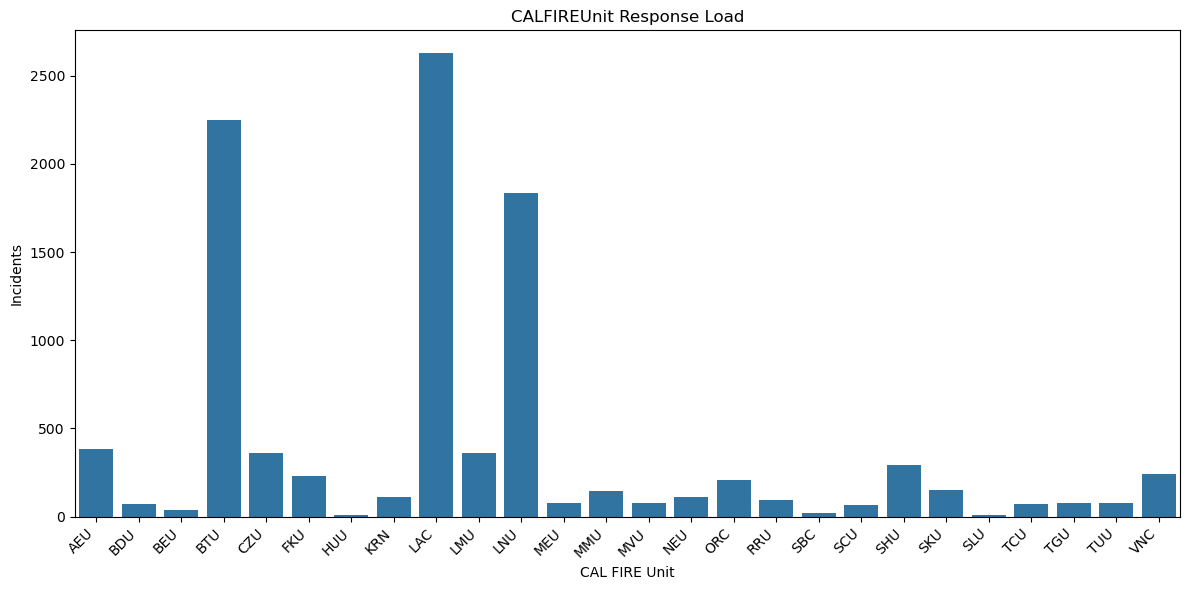

In [209]:
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='CALFIREUnit', y='CALFIREUnitResponseLoad', data=df)
plt.title('CALFIREUnit Response Load')
plt.xlabel('CAL FIRE Unit')
plt.ylabel('Incidents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

**Observations:**
- There is significant variation in the response load across different units
- Los Angeles County is the dominant fire unit, as it has a significantly higher response load compared to all other units

In [210]:
# Find the min and max years
min_year = df['IncidentStartDate'].dt.year.min()
max_year = df['IncidentStartDate'].dt.year.max()

# Calculate the number of years
num_years = max_year - min_year + 1

In [211]:
# Calculate average number of incidents per year for each CAL FIRE unit
df['AverageAnnualLoad'] = df['CALFIREUnitResponseLoad'] / num_years

AverageAnnualLoad represents the average number of incidents a unit responds to per year

In [212]:
df['AverageAnnualLoad'].describe()

count    10000.000000
mean       123.841000
std         76.939044
min          0.538462
25%         27.615385
50%        141.307692
75%        202.000000
max        202.000000
Name: AverageAnnualLoad, dtype: float64

**Observations:**
- On average, each unit has an annual incident load of approximately 123.84
- The standard deviation indicates that the values are somewhat spread out around the mean
- The minimum value of 0.538 indicates that some units have a very low average annual load
- Because the median is higher than the mean, the data is likely left-skewed. There are more units with lower average annual loads than units with very high loads

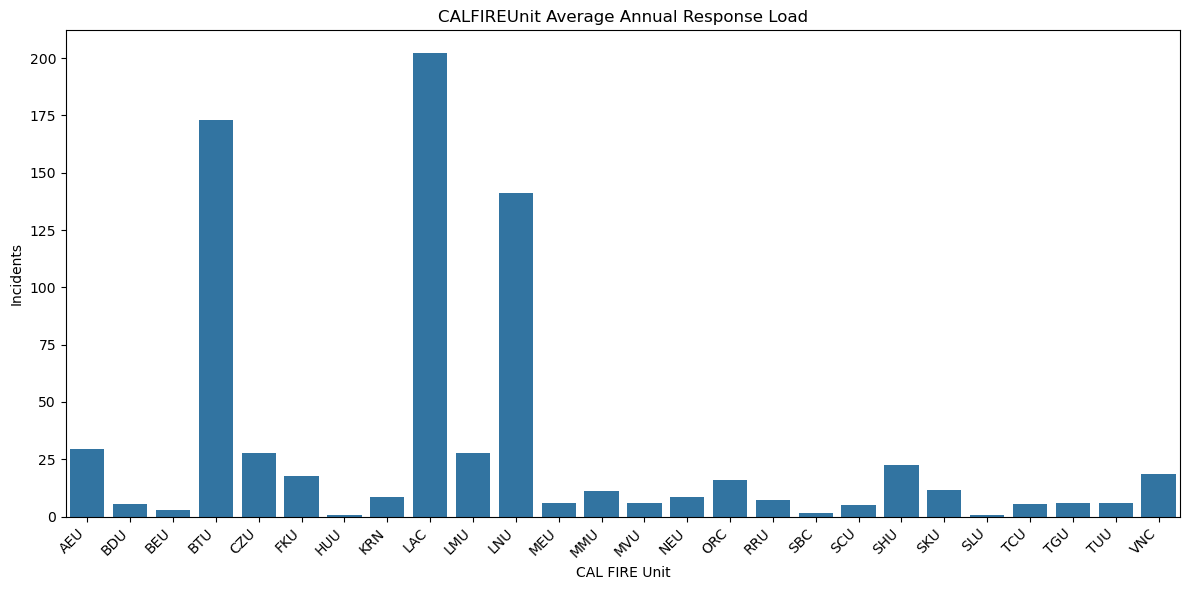

In [213]:
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='CALFIREUnit', y='AverageAnnualLoad', data=df)
plt.title('CALFIREUnit Average Annual Response Load')
plt.xlabel('CAL FIRE Unit')
plt.ylabel('Incidents')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [214]:
# Check summary statistics
df[['CALFIREUnit', 'AverageAnnualLoad']].groupby('CALFIREUnit').mean().sort_values(by='AverageAnnualLoad', ascending=False)

,AverageAnnualLoad
CALFIREUnit,
LAC,202.000000
BTU,173.076923
LNU,141.307692
AEU,29.461538
CZU,27.923077
LMU,27.615385
SHU,22.461538
VNC,18.538462
FKU,17.692308


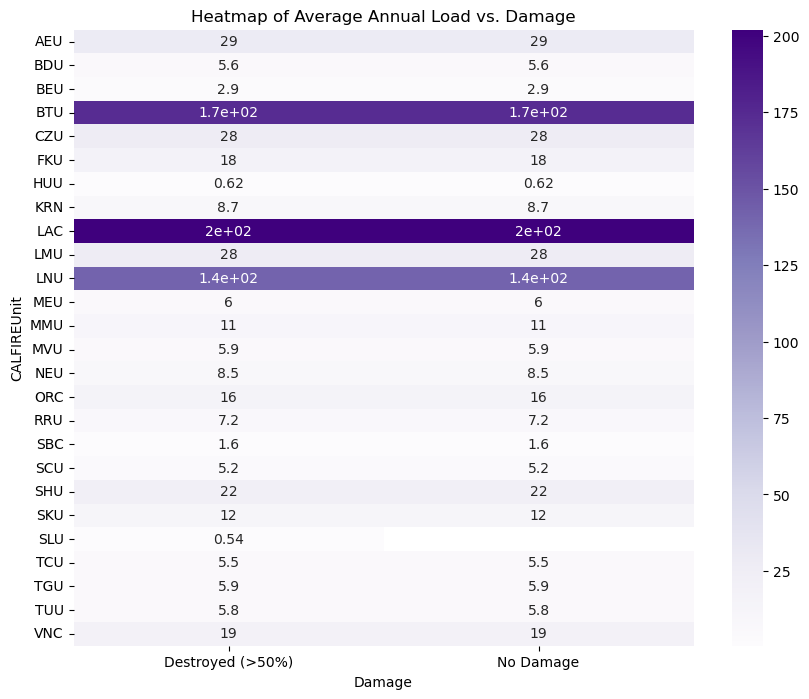

In [215]:
heatmap_data = df.groupby(['CALFIREUnit','Damage'])['AverageAnnualLoad'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='Purples')
plt.title('Heatmap of Average Annual Load vs. Damage')
plt.xlabel('Damage')
plt.ylabel('CALFIREUnit')
plt.show()

In [216]:
# Reduce noise in the dataset by grouping IncidentStartDate into monthly intervals
df['IncidentMonthYear'] = df['IncidentStartDate'].dt.strftime('%b-%y')

In [217]:
response_load = df.groupby(['CALFIREUnit', 'IncidentMonthYear'])['ObjectID'].count().reset_index(name='CALFIREUnitZipCodeResponseLoad')

In [218]:
response_load.describe()

,CALFIREUnitZipCodeResponseLoad
count,1378.000000
mean,7.256894
std,87.015141
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2368.000000


**Observations:**
- The standard deviation is high when compared to the mean, indicating that there are variations in the number of cases that each fire unit responds to (some units have a much higher response load than other units)
- The 25%, 50%, and 75% percentiles are all equal to 0, indicating that the dataset is likely not indicative of the CAL Fire Units actual case load or is highly skewed
- A zero likely means that for a specific CALFIREUnit, ZipCode, and IncidentMonthYear, there were no structures within your dataset recorded as being within that grouping. This could be due to:
    - The fire not impacting that specific area
    - No structures being present in that area
    - Data collection limitations

Will group by zip code and county in order to achieve some additional granuality in the analysis

In [219]:
# Grouping by zip code
response_load_zip = df.groupby(['CALFIREUnit', 'ZipCode', 'IncidentMonthYear'])['ObjectID'].count().reset_index(name='CALFIREUnitZipCodeResponseLoad')

# Grouping by county
response_load_county = df.groupby(['CALFIREUnit', 'County', 'IncidentMonthYear'])['ObjectID'].count().reset_index(name='CALFIREUnitZipCodeResponseLoad')

In [220]:
response_load_zip['CALFIREUnitZipCodeResponseLoad'].describe()

count    241150.000000
mean          0.041468
std           4.376358
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1266.000000
Name: CALFIREUnitZipCodeResponseLoad, dtype: float64

**Observations:**
- The response_load_zip dataframe contains 241,150 rows. Each row represents a unique combination of CALFIREUNit, ZipCode, and IncidentMonthYear
- 75% of values are 0, meaning that most combinations of CalFireUnit, ZipCode, and IncidentMonthYear have no recorded response/incidents
- The data is highly skewed to the right (many zeros)

In [221]:
response_load_zip['Log_ResponseLoad'] = np.log1p(response_load_zip['CALFIREUnitZipCodeResponseLoad'])

# Print descriptive statistics of the transformed data
print(response_load_zip['Log_ResponseLoad'].describe())

count    241150.000000
mean          0.002701
std           0.089658
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.144407
Name: Log_ResponseLoad, dtype: float64


In [222]:
response_load_county.describe()

,CALFIREUnitZipCodeResponseLoad
count,24804.000000
mean,0.403161
std,20.184256
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2368.000000


**Observations:**
- The standard deviation shows a wide spread of values, indicating significant variability
- The high maximum values indicates outliers with extremely high response loads
- The 25%, 50%, and 75% percentiles are all equal to 0, indicating that the dataset is likely not indicative of the CAL Fire Units actual case load or is highly skewed

**Observations after grouping by zip code and country:**
- The data is very sparse after incident case load by zip code and county
- This is partially due to the previous grouping by month
- Will group by year to see if data becomes less sparse

In [223]:
# Reduce noise in the dataset by grouping IncidentStartDate into monthly intervals
df['IncidentYear'] = df['IncidentStartDate'].dt.strftime('%y')

In [224]:
response_load_year = df.groupby(['CALFIREUnit', 'IncidentYear'])['ObjectID'].count().reset_index(name='CALFIREUnitYearlyResponseLoad')

In [225]:
df = df.merge(response_load_year, on=['CALFIREUnit', 'IncidentYear'], how='left')

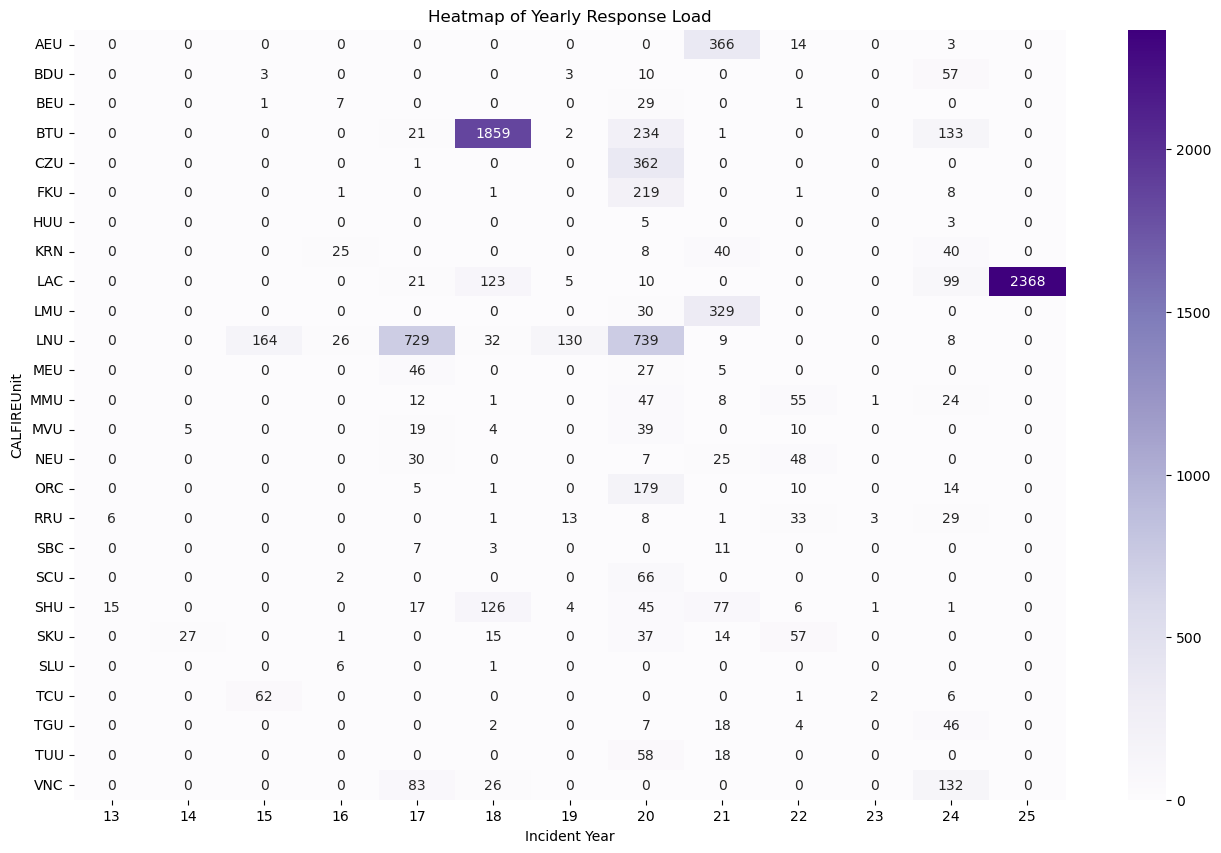

In [226]:
heatmap_data = response_load_year.pivot_table(values='CALFIREUnitYearlyResponseLoad',
                                            index='CALFIREUnit',
                                            columns='IncidentYear',
                                            fill_value=0)

plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap='Purples', annot=True, fmt=".0f")
plt.title('Heatmap of Yearly Response Load')
plt.xlabel('Incident Year')
plt.ylabel('CALFIREUnit')
plt.show()

**Observations:**
- A larger number of cells have a value of 0, indicating that many CAL FIRE units had no recorded responses in certain years. This may be due to an issue in data collection
- High-Load Units:
    - BTU in 2017 responded to 1859 incidents
    - LAC in 2024 responded to 2368 incidents

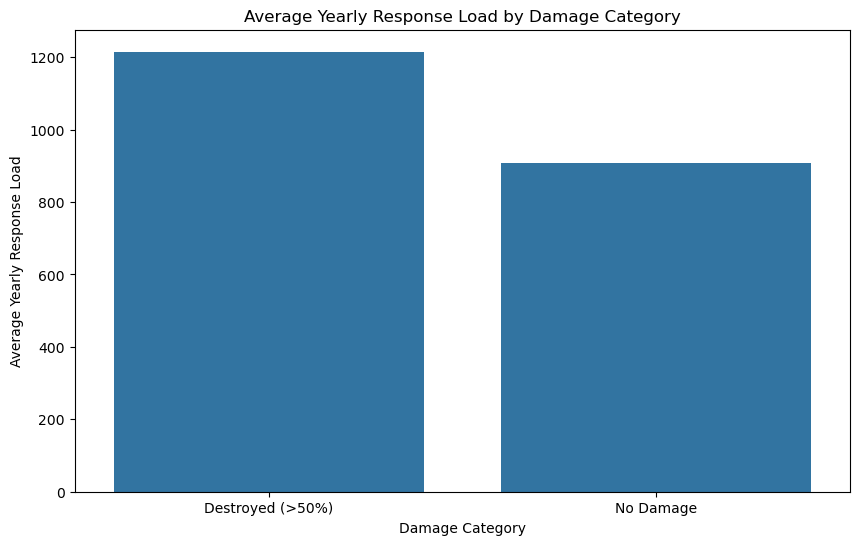

In [227]:
#Aggregate data
aggregated_data = df.groupby('Damage')['CALFIREUnitYearlyResponseLoad'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Damage', y='CALFIREUnitYearlyResponseLoad', data=aggregated_data)
plt.xlabel('Damage Category')
plt.ylabel('Average Yearly Response Load')
plt.title('Average Yearly Response Load by Damage Category')
plt.show()

**Observations:**
- Based on the visualization, there's a potential relationship between yearly response load and damage severity
- On average, incidents that resulted in severe damage were responded to by CAL FIRE units with a higher average case load than incidents with no damage

### Conclusion
In further analysis, response caseloads for units might be indicative of damage due to wildfires
- Units with higher response caseloads are responding to more incidents. This increases exposure to incidents
- Intense incidents often require more resources and time, leading to a higher caseload for units involve
- A high caseload can strain a unit's resources, impacting a unit's effectiveness in fire suppression
The heatmap of yearly response load provided a granular view of incident activity across CAL FIRE Units and incident years
    - Variability in Response Load: Significant variability in response load is evident across different CAL FIRE Units and years. This highlights the localized and temporal nature of wildfire incidents, influenced by factors such as regional climate, vegetation, and human activity
    - High Response Load in Specific Units and Years: Certain CAL FIRE Units (e.g., BTU, LAC, LNU, SKU) exhibited exceptionally high response loads in certain years. This suggests the occurrence of major wildfire events or periods of heightened fire activity in those regions
    - Data Gaps: The heatmap also shows some data gaps, suggesting the need for more complete and consistent data collection in future analysis

## Wrap-Up

In [228]:
df.dtypes

ObjectID                            int64
Damage                           category
StreetType                       category
ZipCode                          category
CALFIREUnit                      category
County                           category
IncidentStartDate                category
StructureType                    category
RoofConstruction                 category
VentScreen                       category
ExteriorSiding                   category
WindowPane                       category
Deck/PorchOnGrade                category
Deck/PorchElevated               category
AssessedImprovedValue             float64
YearBuilt                           int64
Latitude                          float64
Longitude                         float64
Month                               int32
Season                           category
RoofSidingInteraction            category
ZipCodeDensity                      int64
CALFIREUnitResponseLoad             int64
AverageAnnualLoad                 

In [229]:
# Convert all object columns to category
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')

In [230]:
# Write the dataframe to a csv file
df.to_csv('NewFeatures.csv', index=False)